In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
# nltk.download()

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings('ignore')

In [176]:
title_font = {
    "fontsize": 12,
    "fontweight": "semibold",
    "color": "#808080",
    "family": "serif",
    "linespacing": 10
}

label_font = {
    "fontsize": 9,
    "family": "serif",
}

**Описание признаков**
* **uid** - id пользователя
* **rank** - score (0 cоответствует самому популярному комментарию, 4 самому непопулярному)
* **comm_words** - количество слов комментария
* **comm_tags** - количество хэштегов
* **comm_?!_ratio** - число знаков ? и ! в посте по отношению к длине коммента
* **count_smiles** - количество смайликов
* **any_upper** - наличие заглавных букв
* **any_digit** - наличие чисел

### I. Файл train_after_lem.csv

In [3]:
df = pd.read_csv('train_after_lem.csv')
df.head()

,uid,rank,comm,post,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit
0,0,0,back school give founder back school work star...,summer combinator fund decide continue startup...,181,0,0.000000,0,0,1
1,0,1,invariably success set fall back original path...,summer combinator fund decide continue startup...,76,0,0.000000,0,0,0
2,0,2,school connect real world enter school school ...,summer combinator fund decide continue startup...,92,0,0.002045,0,0,0
3,0,3,guess depend hungry product school moment leav...,summer combinator fund decide continue startup...,64,0,0.000000,0,0,1
4,0,4,poll ground back school combinator funding,summer combinator fund decide continue startup...,14,0,0.000000,0,0,0


In [4]:
#Подсчет количества слов каждого комментария
counts_list = []
n=0

while n < 440535:
    word_count = len(df['comm'][n].split())
    counts_list.append(word_count)
    n+=1

df['comm_words'] = np.array(counts_list)

In [5]:
df.head()

,uid,rank,comm,post,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit
0,0,0,back school give founder back school work star...,summer combinator fund decide continue startup...,63,0,0.000000,0,0,1
1,0,1,invariably success set fall back original path...,summer combinator fund decide continue startup...,22,0,0.000000,0,0,0
2,0,2,school connect real world enter school school ...,summer combinator fund decide continue startup...,30,0,0.002045,0,0,0
3,0,3,guess depend hungry product school moment leav...,summer combinator fund decide continue startup...,17,0,0.000000,0,0,1
4,0,4,poll ground back school combinator funding,summer combinator fund decide continue startup...,6,0,0.000000,0,0,0


In [6]:
#440535 наблюдений (объектов), 10 признаков. Пропущенных значений нет.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440535 entries, 0 to 440534
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   uid            440535 non-null  int64  
 1   rank           440535 non-null  int64  
 2   comm           440535 non-null  object 
 3   post           440535 non-null  object 
 4   comm_words     440535 non-null  int64  
 5   comm_tags      440535 non-null  int64  
 6   comm_?!_ratio  440535 non-null  float64
 7   count_smiles   440535 non-null  int64  
 8   any_upper      440535 non-null  int64  
 9   any_digit      440535 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 33.6+ MB


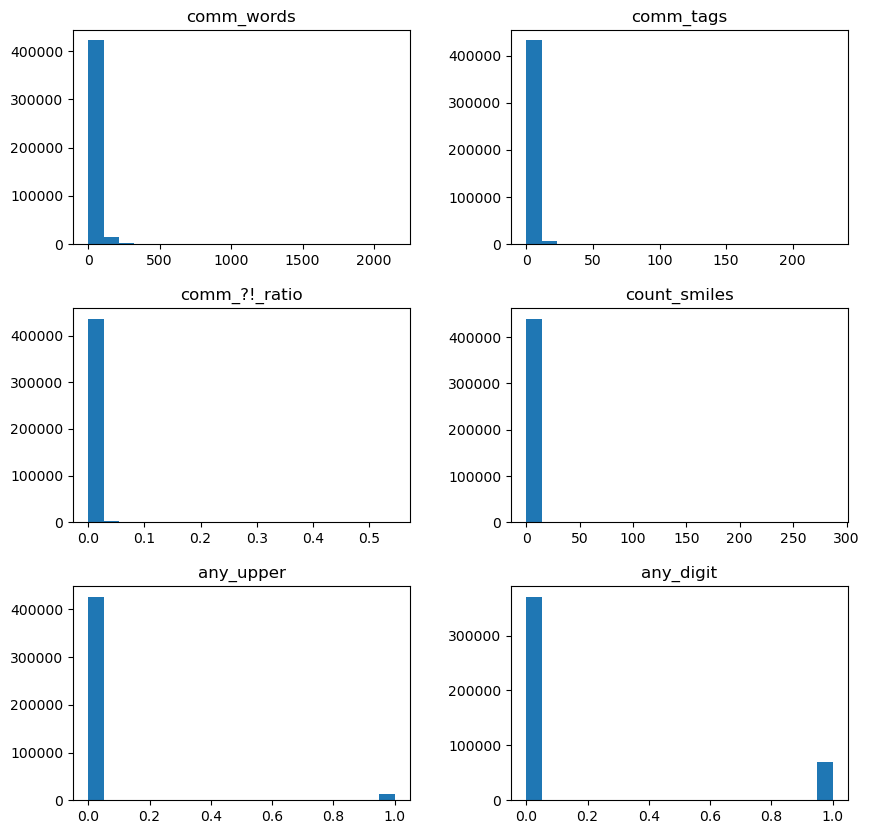

In [7]:
df_num_features = df.select_dtypes(include=['number'])
df_num_features = df_num_features.drop(['uid', 'rank'], axis=1)

df_num_features.hist(figsize=(10, 10), bins=20, grid=False);

**1. Влияние comm_words на rank**

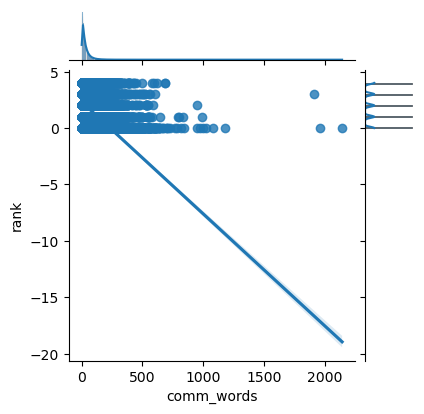

In [8]:
#Соотношение количества слов комментариев с их рангом.
grid = sns.jointplot(df['comm_words'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [9]:
#Стат. данные популярного комментария (rank=0)
df_rank_0 = df.loc[(df['rank']==0) & (df['comm_words'])]
df_rank_0['comm_words'].describe()

count    44070.000000
mean        52.922442
std         54.193685
min          1.000000
25%         19.000000
50%         37.000000
75%         67.000000
max       2143.000000
Name: comm_words, dtype: float64

In [10]:
#медиана популярного/ценного комментария = 37 слов
df_rank_0['comm_words'].median()

37.0

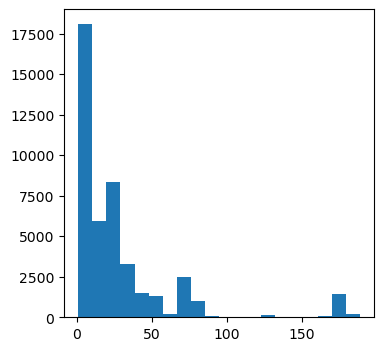

In [11]:
df.loc[df_rank_0['comm_words'], 'comm_words'].hist(figsize=(4, 4), bins=20, grid=False);

In [12]:
#Стат. данные популярного комментария (rank=4)
df_rank_4 = df.loc[(df['rank']==4) & (df['comm_words'])]
df_rank_4['comm_words'].describe()

count    44161.000000
mean        21.417744
std         25.126317
min          1.000000
25%          7.000000
50%         13.000000
75%         27.000000
max        689.000000
Name: comm_words, dtype: float64

In [13]:
#медиана непопулярного комментария = 13 слов
df_rank_4['comm_words'].median()

13.0

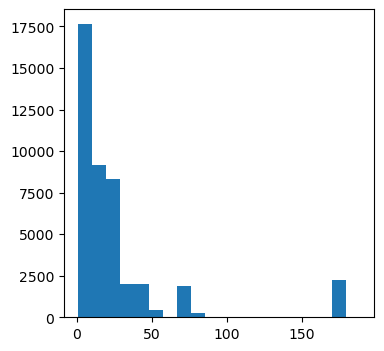

In [14]:
df.loc[df_rank_4['comm_words'], 'comm_words'].hist(figsize=(4, 4), bins=20, grid=False);

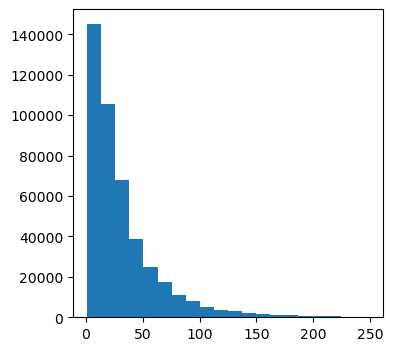

In [15]:
#можно предположить, что значения comm_words > 250 - выбросы.
df.loc[df['comm_words'] < 250, 'comm_words'].hist(figsize=(4, 4), bins=20, grid=False);

In [16]:
#Поменяем значения comm_words > 250 на медианное значение 
#(медиана менее чувствительна к выбросам, чем среднее значение.)

df.loc[df['comm_words'] > 250, 'comm_words'] = df['comm_words'].median()

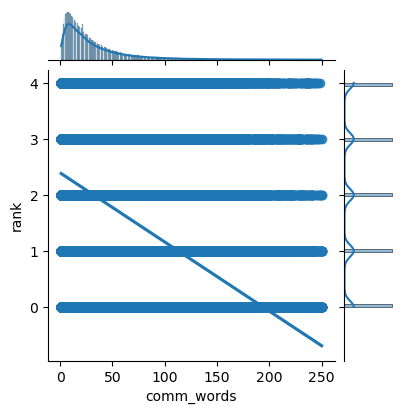

In [17]:
#Посмотрим на соотношение количества слов с рангом комментария после обработки comm_words
grid = sns.jointplot(df['comm_words'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [18]:
df_rank_0 = df.loc[(df['rank']==0) & (df['comm_words'])]
df_rank_0['comm_words'].describe()

count    44625.000000
mean        48.908123
std         42.424095
min          1.000000
25%         19.000000
50%         35.000000
75%         65.000000
max        249.000000
Name: comm_words, dtype: float64

In [19]:
df_rank_4 = df.loc[(df['rank']==4) & (df['comm_words'])]
df_rank_4['comm_words'].describe()

count    44199.000000
mean        21.166022
std         23.292346
min          1.000000
25%          7.000000
50%         13.000000
75%         27.000000
max        247.000000
Name: comm_words, dtype: float64

In [20]:
print('Медиана comm_words rank_0: {}'.format(df_rank_0['comm_words'].median()))
print('Медиана comm_words rank_4: {}'.format(df_rank_4['comm_words'].median()))

Медиана comm_words rank_0: 35.0
Медиана comm_words rank_4: 13.0


**Заключение comm_words & rank:**

Среднее кол-во слов
- rank_0 (популярный коммент) = 48 слов
- rank_4 (непопулярный) = 21 слов

Медиана
- rank_0 = 35 слов
- rank_4 = 13 слов

График корреляции нам дает обратную зависимость: больше слов - популярнее комментарий (до 200 слов)

**2. Влияние comm_tags на rank**

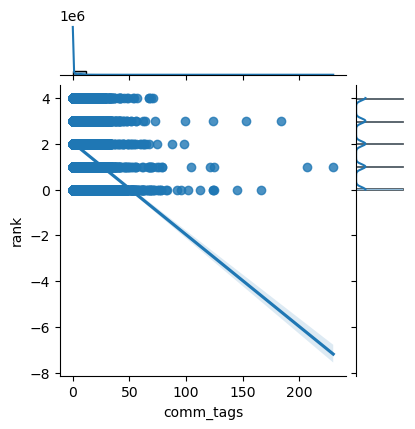

In [21]:
grid = sns.jointplot(df['comm_tags'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [22]:
#Стат. данные популярного комментария (rank=0)
df_rank_0 = df.loc[(df['rank']==0) & (df['comm_tags'])]
df_rank_0['comm_tags'].describe()

count    12247.000000
mean         6.322283
std          7.002991
min          1.000000
25%          1.000000
50%          5.000000
75%          9.000000
max        145.000000
Name: comm_tags, dtype: float64

In [23]:
#Стат. данные непопулярного комментария (rank=4)
df_rank_4 = df.loc[(df['rank']==0) & (df['comm_tags'])]
df_rank_4['comm_tags'].describe()

count    12247.000000
mean         6.322283
std          7.002991
min          1.000000
25%          1.000000
50%          5.000000
75%          9.000000
max        145.000000
Name: comm_tags, dtype: float64

In [24]:
print('Медиана comm_tags rank_0: {}'.format(df_rank_0['comm_tags'].median()))
print('Медиана comm_tags rank_4: {}'.format(df_rank_4['comm_tags'].median()))

Медиана comm_tags rank_0: 5.0
Медиана comm_tags rank_4: 5.0


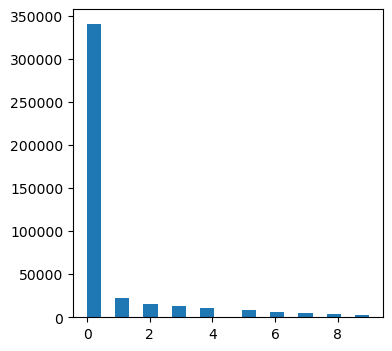

In [25]:
#можно предположить, что значения comm_tags > 10 - выбросы.

df.loc[df['comm_tags'] < 10, 'comm_tags'].hist(figsize=(4, 4), bins=20, grid=False);

In [26]:
#Поменяем значения comm_tags > 10 на медианное значение 

df.loc[df['comm_tags'] > 10, 'comm_tags'] = df['comm_tags'].median()

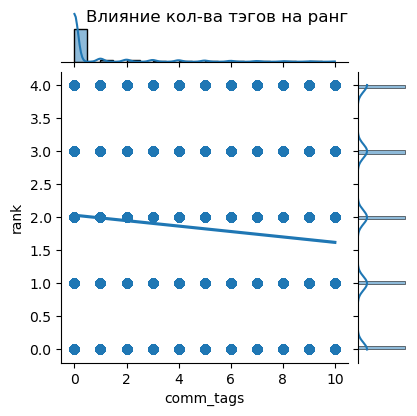

In [27]:
#Посмотрим на данные после обработки выбросов

grid = sns.jointplot(df['comm_tags'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)
grid.fig.suptitle("Влияние кол-ва тэгов на ранг")

plt.show()

In [28]:
df_rank_0 = df.loc[(df['rank']==0) & (df['comm_tags'])]
df_rank_0['comm_tags'].describe()

count    10010.000000
mean         3.833367
std          2.636920
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          9.000000
Name: comm_tags, dtype: float64

In [29]:
df_rank_4 = df.loc[(df['rank']==4) & (df['comm_tags'])]
df_rank_4['comm_tags'].describe()

count    10061.000000
mean         2.740384
std          2.238687
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          9.000000
Name: comm_tags, dtype: float64

In [30]:
print('Медиана comm_tags rank_0: {}'.format(df_rank_0['comm_tags'].median()))
print('Медиана comm_tags rank_4: {}'.format(df_rank_4['comm_tags'].median()))

Медиана comm_tags rank_0: 3.0
Медиана comm_tags rank_4: 1.0


**Заключение comm_tags & rank:** 

Среднее кол-во хэштегов
* rank_0 (популярный коммент) = 3
* rank_4 (непопулярный) = 3 (2.7)

Медиана
* rank_0 = 3
* rank_4 = 1

Значительного влияния наличие и количество хэштегов на ранг комментария нет.

**3. Влияние count_smiles на rank**

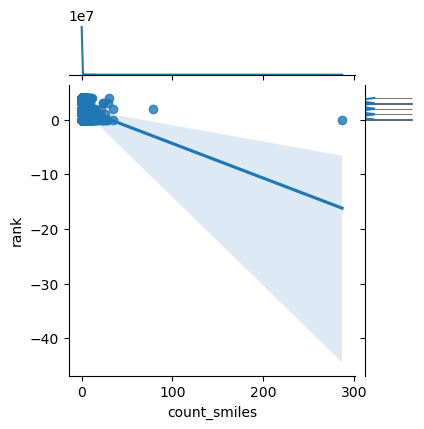

In [31]:
grid = sns.jointplot(df['count_smiles'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

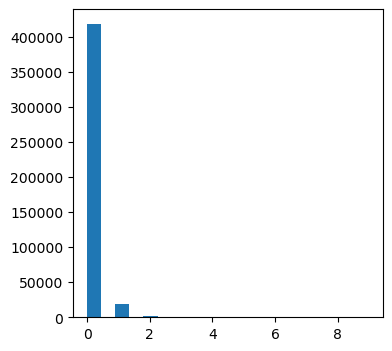

In [32]:
df.loc[df['count_smiles'] < 10, 'count_smiles'].hist(figsize=(4, 4), bins=20, grid=False);

In [33]:
#Коли-во смайликов больше 10 - выбросы. Меняем на медиану.
df.loc[df['count_smiles'] > 10, 'count_smiles'] = df['count_smiles'].median()

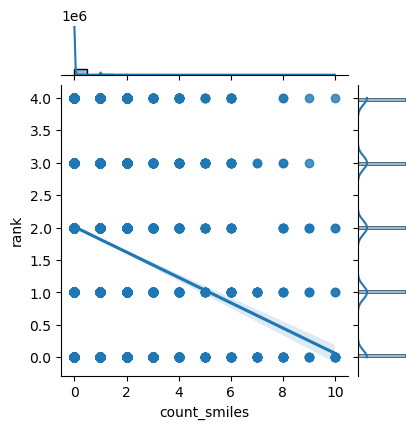

In [34]:
#влияние кол-ва смайлов на rank: 

grid = sns.jointplot(df['count_smiles'], df['rank'], kind='reg')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [35]:
#Стат-ка популярного комментария (rank=0)
df_rank_0 = df.loc[(df['rank']==0) & (df['count_smiles'])]
df_rank_0['count_smiles'].describe()

count    4986.000000
mean        1.101484
std         0.580639
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: count_smiles, dtype: float64

In [36]:
#Стат-ка непопулярного комментария (rank=4)
df_rank_4 = df.loc[(df['rank']==4) & (df['count_smiles'])]
df_rank_4['count_smiles'].describe()

count    3418.000000
mean        1.027501
std         0.278702
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: count_smiles, dtype: float64

**Заключение comm_tags & rank:** 

Среднее кол-во хэштегов
* rank_0 (популярный коммент) = 1
* rank_4 (непопулярный) = 1

Медиана
* rank_0 = 1
* rank_4 = 1

Значительного влияния наличие и количество смайликов на ранг комментария нет.

**4. Исследование any_upper относительно rank**

In [37]:
df_rank_0 = df.loc[(df['rank']==0) & (df['any_upper'])]
print(df_rank_0['any_upper'].value_counts())

df_rank_0 = df.loc[(df['rank']==0) & (df['any_upper']==False)]
print(df_rank_0['any_upper'].value_counts())

1    3088
Name: any_upper, dtype: int64
0    85019
Name: any_upper, dtype: int64


In [38]:
df_rank_4 = df.loc[(df['rank']==4) & (df['any_upper'])]
print(df_rank_0['any_upper'].value_counts())

df_rank_4 = df.loc[(df['rank']==4) & (df['any_upper']==False)]
print(df_rank_0['any_upper'].value_counts())

0    85019
Name: any_upper, dtype: int64
0    85019
Name: any_upper, dtype: int64


**Заключение:** наличие заглавных букв не влияет на ранг.

**5. Исследование any_digit относительно rank**

In [39]:
df_rank_0 = df.loc[(df['rank']==0) & (df['any_digit'])]
print(df_rank_0['any_digit'].value_counts())

df_rank_0 = df.loc[(df['rank']==0) & (df['any_digit']==False)]
print(df_rank_0['any_digit'].value_counts())

1    19807
Name: any_digit, dtype: int64
0    68300
Name: any_digit, dtype: int64


In [40]:
df_rank_4 = df.loc[(df['rank']==4) & (df['any_digit'])]
print(df_rank_0['any_digit'].value_counts())

df_rank_4 = df.loc[(df['rank']==4) & (df['any_digit']==False)]
print(df_rank_0['any_digit'].value_counts())

0    68300
Name: any_digit, dtype: int64
0    68300
Name: any_digit, dtype: int64


**Заключение:** наличие чисел не влияет на ранг.

**Матричная корреляция**

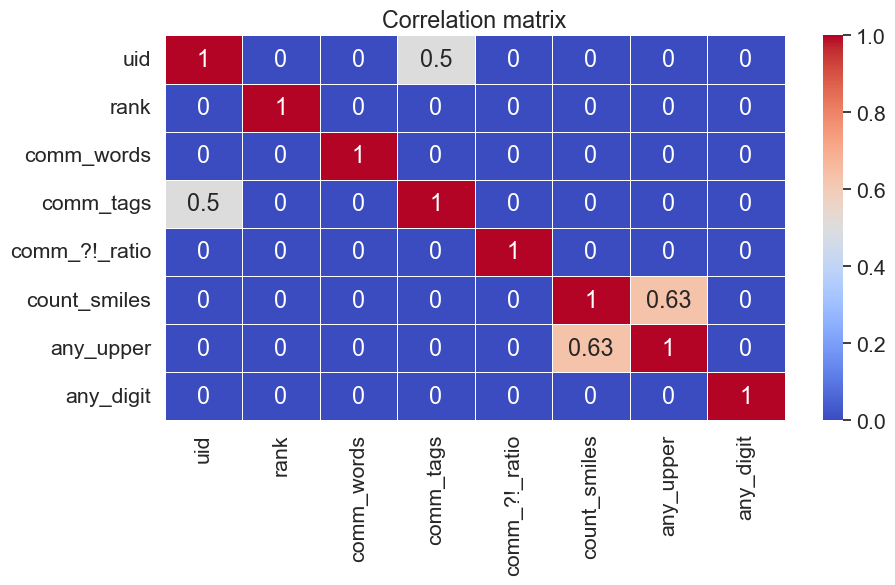

In [41]:
plt.figure(figsize = (10,5))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

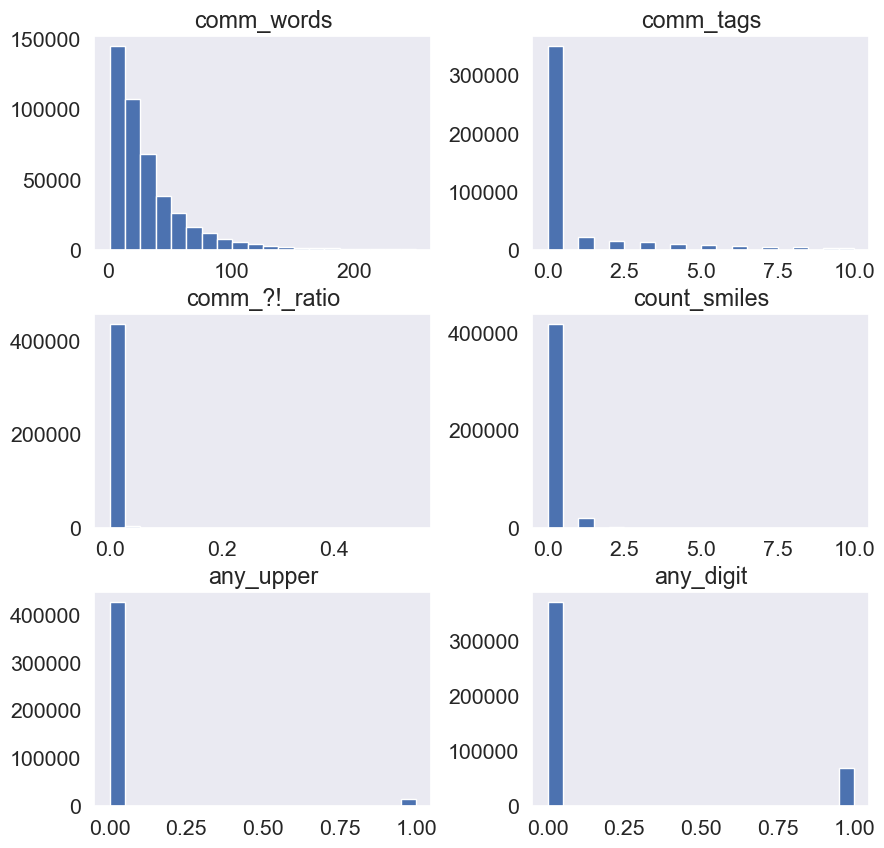

In [42]:
#Посмотрим еще раз на сводку графиков после обработки выбросов
df_num_features = df.select_dtypes(include=['number'])
df_num_features = df_num_features.drop(['uid', 'rank'], axis=1)

df_num_features.hist(figsize=(10, 10), bins=20, grid=False);

In [43]:
df.to_csv('train_after_lem_eda.csv', index= False)

### II. Файл cols_without_text.csv

**Описание признаков**
* **similar_with_Jaccard** - метрика Jaccard для схожести поста и коммента
* **post_comm** - косинусное расстояние для схожести поста и коммента (схожесть векторов по косинусу помогаем в решении задач обработки естественного языка.)
* **post_comm2_1** - post_comm^2*(1-post_comm)
* **similar_with_Jaccard2_1** - similar_with_Jaccard^2*(1-similar_with_Jaccard)
* **comm_comm_min** - косинусное расстояние для схожести текущего коммента с другими к этому посту (минимальное)
* **comm_comm_mean** - косинусное расстояние для схожести текущего коммента с другими к этому посту (среднее)
* **comm_comm_max** - косинусное расстояние для схожести текущего коммента с другими к этому посту (максимальное)
* **sent_score** - скор настроения коммента (положительный скор - положительный сентимент)
* **post_and_comm_sent** - флаг совпадает ли настроение поста и коммента


In [380]:
data = pd.read_csv('cols_without_text.csv')
data.head(10)

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,post_comm2_1,similar_with_Jaccard2_1,comm_comm_mean,comm_comm_max,post_and_comm_sent,sent_score,comm_comm_min
0,0,0,181,0.0,0.000000,0,0,1,0.146341,0.845574,0.110414,0.018282,0.898585,0.937140,0,-0.9531,0.802385
1,0,1,76,0.0,0.000000,0,0,0,0.115385,0.878685,0.093666,0.011777,0.911822,0.940139,0,0.9081,0.836558
2,0,2,92,0.0,0.002045,0,0,0,0.030303,0.856563,0.105240,0.000890,0.914719,0.947184,0,0.7650,0.834412
3,0,3,64,0.0,0.000000,0,0,1,0.041667,0.901070,0.080324,0.001664,0.922313,0.947184,0,-0.0516,0.885877
4,0,4,14,0.0,0.000000,0,0,0,0.250000,0.918926,0.068461,0.046875,0.839808,0.885877,0,0.0000,0.802385
5,1,0,48,0.0,0.000000,0,0,0,0.050000,0.840234,0.112794,0.002375,0.887058,0.918644,0,0.9081,0.865455
6,1,1,21,0.0,0.008065,0,0,0,0.000000,0.838449,0.113570,0.000000,0.888782,0.912677,0,-0.3818,0.864761
7,1,2,14,0.0,0.000000,0,0,0,0.000000,0.859816,0.103636,0.000000,0.892943,0.918644,0,0.4215,0.864211
8,1,3,12,0.0,0.000000,0,0,0,0.000000,0.870541,0.098110,0.000000,0.872047,0.893762,0,0.2263,0.864211
9,1,4,16,0.0,0.000000,0,0,0,0.000000,0.865384,0.100813,0.000000,0.895450,0.912677,0,0.0000,0.885825


In [381]:
data['comm_words'] = df['comm_words']
data.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,post_comm2_1,similar_with_Jaccard2_1,comm_comm_mean,comm_comm_max,post_and_comm_sent,sent_score,comm_comm_min
0,0,0,63,0.0,0.000000,0,0,1,0.146341,0.845574,0.110414,0.018282,0.898585,0.937140,0,-0.9531,0.802385
1,0,1,22,0.0,0.000000,0,0,0,0.115385,0.878685,0.093666,0.011777,0.911822,0.940139,0,0.9081,0.836558
2,0,2,30,0.0,0.002045,0,0,0,0.030303,0.856563,0.105240,0.000890,0.914719,0.947184,0,0.7650,0.834412
3,0,3,17,0.0,0.000000,0,0,1,0.041667,0.901070,0.080324,0.001664,0.922313,0.947184,0,-0.0516,0.885877
4,0,4,6,0.0,0.000000,0,0,0,0.250000,0.918926,0.068461,0.046875,0.839808,0.885877,0,0.0000,0.802385


**1. Косинусная схожесть комментария с постом Post_comm**

Гипотеза: чтобы коммент был популярен, он должен быть связан с постом (меньше расстояние). Чем больше значение в промежутке [0, 1], тем схожесть выше.

In [382]:
rank_0_pc = data.loc[(df['rank']==0), 'post_comm']
rank_4_pc = data.loc[(df['rank']==4), 'post_comm']

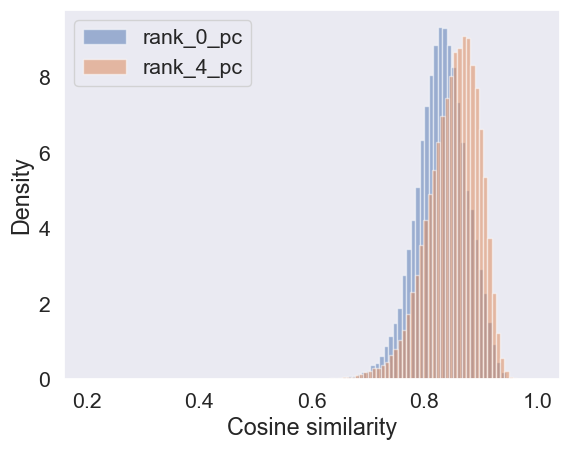

In [383]:
rank_0_pc.hist(bins=100, grid=False,density=True, label='rank_0_pc', alpha=0.5);
rank_4_pc.hist(bins=100, grid=False,density=True, label='rank_4_pc', alpha=0.5);

plt.xlabel("Сosine similarity")
plt.ylabel("Density")

plt.legend()

In [384]:
rank_0_pc.describe()

count    88107.000000
mean         0.829600
std          0.045572
min          0.199238
25%          0.801574
50%          0.831215
75%          0.860131
max          1.000000
Name: post_comm, dtype: float64

In [385]:
rank_4_pc.describe()

count    88107.000000
mean         0.850559
std          0.046260
min          0.229154
25%          0.822710
50%          0.856225
75%          0.884138
max          0.987484
Name: post_comm, dtype: float64

In [386]:
print('Медиана кос.расстояния rank=0: {}'.format(rank_0_pc.median()))
print('Медиана кос.расстояния rank=4: {}'.format(rank_4_pc.median()))

Медиана кос.расстояния rank=0: 0.8312146904595252
Медиана кос.расстояния rank=4: 0.8562254507867594


**Заключение:**

* Среднее значение rank=0  (попул.коммент.): 0.83
* Среднее значение rank=4 (непопул. коммент): 0.85

* Медиана rank=0: 0.83
* Медиана rank=4: 0.86

На графике видим небольшое различие: кос.схожесть у попул. комментария несколько ниже, чем у поп.комментария. Можно предположить, что чтобы комментарий получил отклик у аудитории (стал популярным) не стоит дублировать смысл поста, а необходимо выразить свое мнение.

**2. Косинусная схожесть комментария с постом Post_comm2_1**

Гипотеза: не только большое, но и очень близкое расстояние коммента к посту снижает популярность

Косинусная схожесть популярного комментария с постом:
min = 0, 
max = 0.8

Косинусная схожесть непопулярного комментария с постом:
min = 0, 
max = 0.8

**3. Косинусная схожесть комментария с другим комментарием Comm_comm_max**

Гипотеза: комменты с большим максимальным расстоянием (comm_comm_max) совпадают по смыслу с другими комментами и, значит, будут популярны.

In [387]:
#Найдем среднюю кос.схожесть комментария по каждому рангу

ccm_mean_rank = []
n = 0

while n < 5:
    ccm_mean = data.loc[(df['rank']==n),'comm_comm_max'].mean()
    ccm_mean_rank.append(ccm_mean)
    print(f'Ср. кос.схожесть rank={n}: {ccm_mean}')
    n+=1
    
    
ccm_mean_rank = np.array(ccm_mean_rank)

Ср. кос.схожесть rank=0: 0.9318352223644428
Ср. кос.схожесть rank=1: 0.9305250001130424
Ср. кос.схожесть rank=2: 0.928138445587836
Ср. кос.схожесть rank=3: 0.9251834523149656
Ср. кос.схожесть rank=4: 0.921117837340058


In [388]:
x = data['rank'].unique()
y = ccm_mean_rank

Text(0, 0.5, 'Cos')

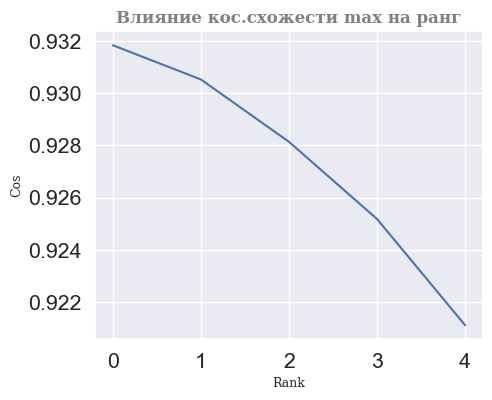

In [389]:
fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches(5, 4)
fig.subplots_adjust(wspace=0.3)

ax.plot(x, y)
ax.set_title('Влияние кос.схожести max на ранг', fontdict=title_font )
ax.set_xlabel('Rank', fontdict=label_font)
ax.set_ylabel('Cos', fontdict=label_font)

**Заключение:**
Чем выше значение максимальной кос. схожести одного комментария относительного других, тем выше ранг (комментарий популярнее).
Совпадают по смыслу с другими комментами и, значит, будут популярны.

**4.Sent_score**

Гипотеза: позитивные комменты популярнее (ближе к rank=0)

In [390]:
#Найдем кол-во позитивных и негативных комментариев в каждом ранге

positive_str_rank = []
negative_str_rank = []
n = 0

while n < 5:
    positive_str = data[(data['rank']==n) & data['sent_score']>0].shape[0]
    positive_str_rank.append(positive_str)
    negative_str = data[(data['rank']==n)&(data['sent_score']<0)].shape[0]
    negative_str_rank.append(negative_str)
    print(f'Positive rank={n}: {positive_str}')
    print(f'Negative rank={n}: {negative_str}')
    n+=1


Positive rank=0: 81970
Negative rank=0: 23375
Positive rank=1: 78696
Negative rank=1: 22492
Positive rank=2: 75926
Negative rank=2: 21684
Positive rank=3: 73510
Negative rank=3: 21282
Positive rank=4: 70855
Negative rank=4: 20608


In [392]:
data_for_hist = pd.DataFrame({'Rank': data['rank'].unique(),
 'Positive com-s': positive_str_rank,
 'Negative com-s': negative_str_rank})
data_for_hist

,Rank,Positive com-s,Negative com-s
0,0,81970,23375
1,1,78696,22492
2,2,75926,21684
3,3,73510,21282
4,4,70855,20608


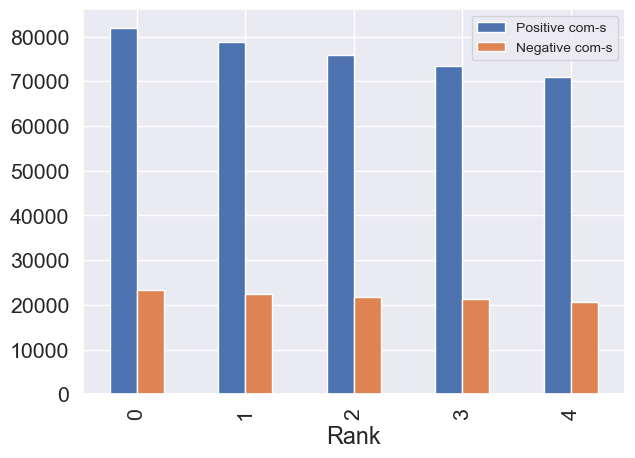

In [401]:
data_for_hist[['Rank', 'Positive com-s', 'Negative com-s']].plot(x ='Rank', kind='bar', figsize=(7, 5)) 
plt.legend(loc="upper right", frameon=True, fontsize=10)

In [394]:
#Посчитаем отношение позитивн. коммент. к негативным в каждом ранге
n = 0
print('Отношение позитивных к негативным: ')

while n < 5:
    coeff = round(data_for_hist['Positive com-s'][n]/data_for_hist['Negative com-s'][n], 3)
    print(f'rank={n}: {coeff}')
    n+=1

Отношение позитивных к негативным: 
rank=0: 3.507
rank=1: 3.499
rank=2: 3.501
rank=3: 3.454
rank=4: 3.438


**Заключение:**

Соотношение позитивных комментов к негативным показало, что чем больше позитивных и меньше негативных смыслов в комментарии, тем скор выше (rank стремиться к нулю, комментарий популярнее).

**5. Post_and_comm_sent**

Задача: посмотреть, какие комменты популярнее - те, которые совпадают по эмоции с постом (True, 1) или, наоборот, имеют противоположную эмоцию (False, 0)

In [395]:
false_count = []
true_count = []
n = 0

while n < 5:
    value = data.loc[(data['rank']==n), 'post_and_comm_sent'].value_counts()
    false_count.append(value[0])
    true_count.append(value[1])
    n+=1

print(false_count)
print(true_count)

[69200, 69896, 70544, 70981, 71515]
[18907, 18211, 17563, 17126, 16592]


In [396]:
data_for_hist_pcs = pd.DataFrame({'Rank': data['rank'].unique(),
 'False': false_count,
 'True': true_count})
data_for_hist_pcs

,Rank,False,True
0,0,69200,18907
1,1,69896,18211
2,2,70544,17563
3,3,70981,17126
4,4,71515,16592


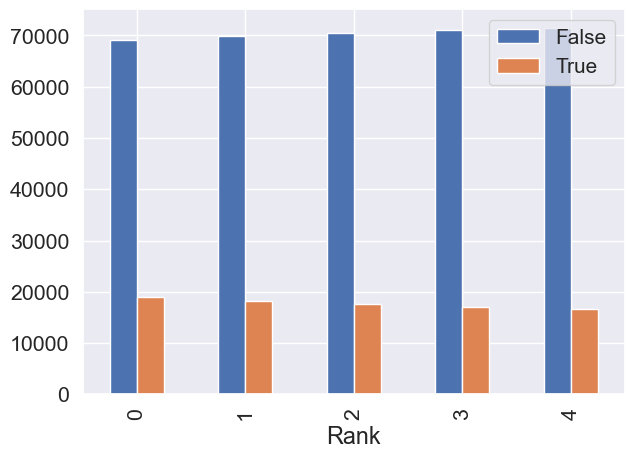

In [403]:
data_for_hist_pcs[['Rank', 'False', 'True']].plot(x ='Rank', kind='bar', figsize=(7, 5)) 
plt.legend(loc="upper right", frameon=True, fontsize=15)

In [398]:
#Посчитаем отношение False (комментарий имеет противоположную эмоцию от эмоции поста)
# к True (комментарий близок по эмоции с постом) в каждом ранге.

n = 0
print('Отношение False к True: ')

while n < 5:
    coeff = round(data_for_hist_pcs['False'][n]/data_for_hist_pcs['True'][n], 3)
    print(f'rank={n}: {coeff}')
    n+=1

Отношение False к True: 
rank=0: 3.66
rank=1: 3.838
rank=2: 4.017
rank=3: 4.145
rank=4: 4.31


**Заключение:**

Прослеживается тенденция: комментарий популярнее в случае, если его эмоциональный посыл совпадает с посылом публикации.

In [404]:
df.to_csv('cols_without_text_wordcount.csv', index= False)

# WordCloud

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

In [3]:
df = pd.read_csv('train_after_lem.csv')
df.head()

,uid,rank,comm,post,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard
0,0,0,back school give founder back school work star...,summer combinator fund decide continue startup...,181,0,0.000000,0,0,1,0.146341
1,0,1,invariably success set fall back original path...,summer combinator fund decide continue startup...,76,0,0.000000,0,0,0,0.115385
2,0,2,school connect real world enter school school ...,summer combinator fund decide continue startup...,92,0,0.002045,0,0,0,0.030303
3,0,3,guess depend hungry product school moment leav...,summer combinator fund decide continue startup...,64,0,0.000000,0,0,1,0.041667
4,0,4,poll ground back school combinator funding,summer combinator fund decide continue startup...,14,0,0.000000,0,0,0,0.250000


In [4]:
def gen_wc(txt):
    """
    строит облако
    """

    wc = WordCloud(width=800, height=400, background_color="white", max_font_size=300, max_words = 50).generate(txt)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

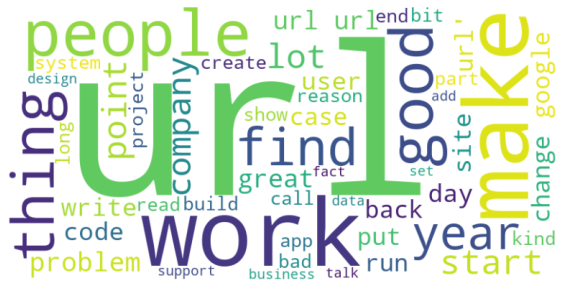

In [5]:
#слова популярных комментариев без удаления стоп-слов
rank_0 = str(list(df[df['rank']==0]['comm']))
gen_wc(rank_0)

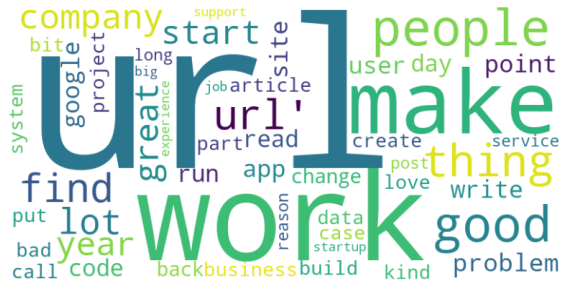

In [6]:
#слова непопулярных комментариев без удаления стоп-слов
rank_4 = str(list(df[df['rank']==4]['comm']))
gen_wc(rank_4)

In [7]:
def gen_wc_arr(txt): 
    """
    возвращает самые популярные слова
    """
    wc = WordCloud().generate(txt)
    freq_dict = wc.process_text(txt)
    top_n_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    return top_n_words  

In [8]:
rank_0_arr = gen_wc_arr(rank_0)
rank_0_list = [i[0] for i in rank_0_arr][:1000]
rank_0_list = rank_0_list + ['ago', 'ly', 'apps', 'bottom', 'mam', 'dollar', 'coin', 'credit', 'hundred', 'billion', 'tv', 'though', 'thousand']

In [9]:
rank_4_arr = gen_wc_arr(rank_4)
rank_4_list = [i[0] for i in rank_4_arr][:1000]
rank_4_list = rank_4_list +['ago', 'ly', 'apps', 'bottom', 'mam', 'dollar', 'coin', 'might', 'hundred', 'billion', 'hub', 'thousand', 'though', 'etc', 'luck', 'center']

Облака с обработкой стоп-слов

In [10]:
def gen_wc_sw(txt, stopwords):
    """
    строит облако со стопсловами
    """

    wc = WordCloud(width=800, height=400,  stopwords=stopwords, background_color="white", max_font_size=300, max_words = 50).generate(txt)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

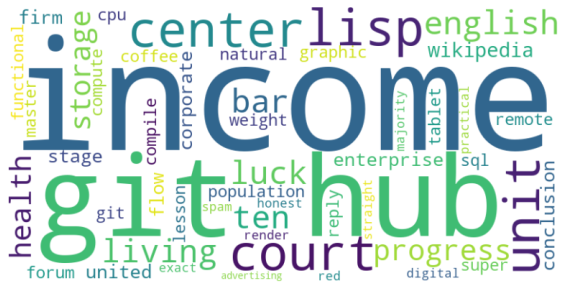

In [11]:
#слова популярных комментариев с удалением стоп-слов (rank_0)

stopwords = set(STOPWORDS).union(rank_0_list)

gen_wc_sw(rank_0, stopwords)

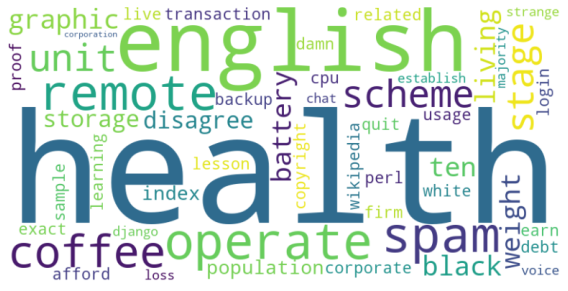

In [12]:
#слова непопулярных комментариев с удалением стоп-слов (rank_4)
stopwords = set(STOPWORDS).union(rank_4_list)

gen_wc_sw(rank_4, stopwords)

In [13]:
rank_0_set = set(rank_0_list)
rank_4_set = set(rank_4_list)

In [14]:
#слова, которые есть в множестве rank_0, но нет в rank_4
len(rank_0_set.difference(rank_4_set))

64

In [15]:
#слова, которые есть в множестве rank_4, но нет в rank_0
len(rank_4_set.difference(rank_0_set))

67

### Частотные биграммы

In [18]:
#Токенизация
rank_0_tokens = word_tokenize(rank_0)
rank_0_text = nltk.Text(rank_0_tokens)
print(type(rank_0_text))

<class 'nltk.text.Text'>


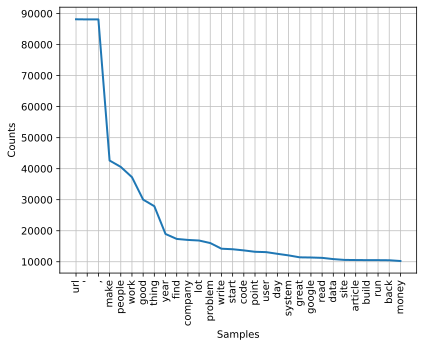

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [20]:
#Подсчёт статистики распределения частот слов в тексте  комментариев rank_0
fdist = FreqDist(rank_0_text)
fdist.plot(30,cumulative=False)

In [22]:
english_stopwords = stopwords.words("english")

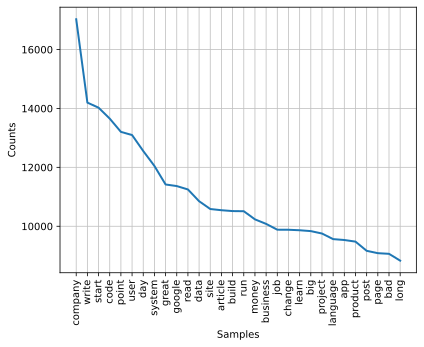

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [23]:
english_stopwords = english_stopwords + ["url", "'", ",", "make", "people", "work", "good", "thing", 
                                         "year", "find", "[", "back", "give", "ly", "problem", "lot"]

list_without_sw = [word for word in rank_0_text if not word in english_stopwords]

fdist_sw = FreqDist(list_without_sw)
fdist_sw.plot(30,cumulative=False)

Text(0.5, 1.0, 'TOP 10 словосочетаний комментария rank=0')

<Figure size 1000x500 with 0 Axes>

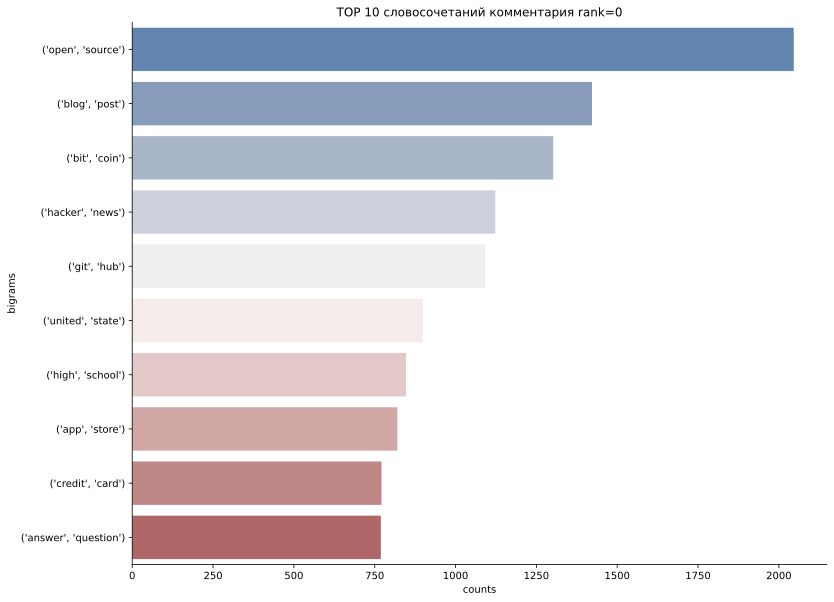

In [24]:
# Создаем датасет самых частотных биграммов
bigrams_series = (pd.Series(nltk.ngrams(list_without_sw, 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграммов
plt.figure(figsize=(10,5))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="vlag", data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('TOP 10 словосочетаний комментария rank=0')